Montar drive



In [7]:
#montar el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Dependencias, seed y utilidades

In [8]:
import sys
from pathlib import Path

# Agregar carpeta src al path
sys.path.append(str(Path("/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4") / "src"))

import importlib
import utils.config_rutas as cr
importlib.reload(cr)

print("Usando:", cr.__file__)


Usando: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/src/utils/config_rutas.py


In [22]:
# instalar dependencias que se usa para el notebook
!pip -q install scikit-learn pandas numpy matplotlib joblib

#import y utilidades
import os, json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib


from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from utils import config_rutas as rutas
import joblib

# Semilla para resultados reproducibles (mismos valores)
seed = 42
random.seed(seed); np.random.seed(seed)

# Identificador de archivos
id_arch = "01_"

#Utilidades de guardado
def _ensure_parent(p):
    p = Path(p); p.parent.mkdir(parents=True, exist_ok=True); return p

def save_json(obj, path):
    p = _ensure_parent(path)
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    print("JSON guardado en:", p)

def save_fig(path):
    p = _ensure_parent(path)
    plt.savefig(p, dpi=160, bbox_inches="tight")
    plt.close()
    print("Imagen guardada en:", p)

Cargar dataset

In [10]:
# Ruta del archivo limpio y balanceado
raw_dir = rutas.get_raw_dir()

# Ajusta el nombre si tu archivo se llama distinto
data_csv = raw_dir / "amazon_reviews_limpio_balanceado.csv"

# Carga del csv
df = pd.read_csv(data_csv)
print("Tamaño del dataset:", df.shape)
print("Columnas:", df.columns.tolist())
df.head(3)


Tamaño del dataset: (30000, 6)
Columnas: ['text', 'label', 'overall', 'mention_price', 'mention_quality', 'mention_shipping']


,text,label,overall,mention_price,mention_quality,mention_shipping
0,"Bought this for my husband (iphone 4), he had ...",positive,5.0,False,True,False
1,For under $20 I wasn't expecting much but was ...,positive,5.0,True,True,False
2,Thanks,neutral,3.0,False,False,False


Descripción general

In [12]:
print('Tipos de datos:')
print(df.dtypes.astype(str))
print('\nValores nulos por columna:')
print(df.isnull().sum())

Tipos de datos:
text                 object
label                object
overall             float64
mention_price          bool
mention_quality        bool
mention_shipping       bool
dtype: object

Valores nulos por columna:
text                0
label               0
overall             0
mention_price       0
mention_quality     0
mention_shipping    0
dtype: int64


Análisis exploratorio

Conteo de sentimientos:
 label
positive    10000
neutral     10000
negative    10000
Name: count, dtype: int64

Conteo de menciones:
 {'precio': 6644, 'calidad': 11322, 'envío': 3560}


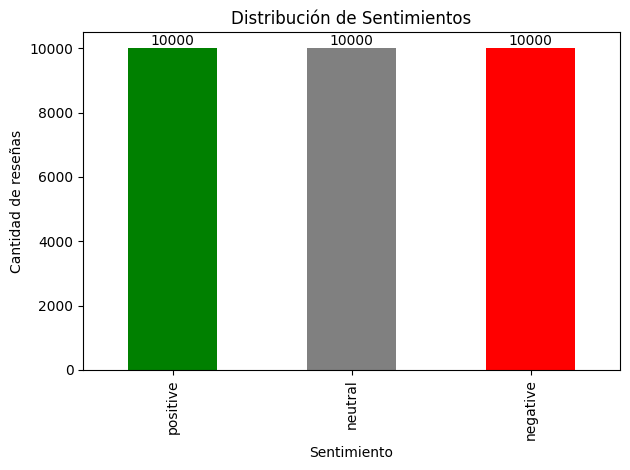

 Guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_distribucion_sentimientos.png


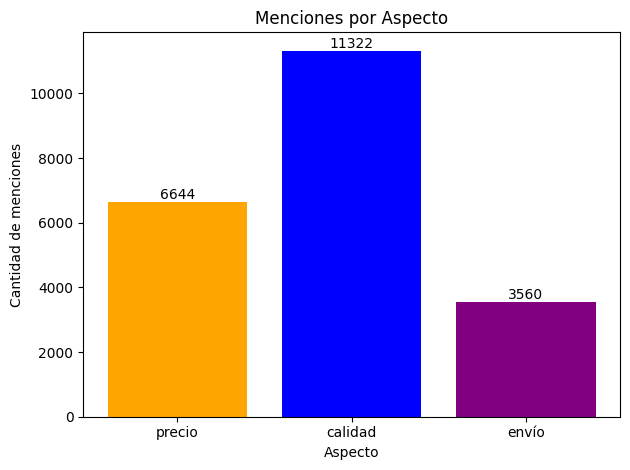

Guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_menciones_por_aspecto.png


In [23]:
# Rutas desde tu módulo
images_dir    = Path(rutas.get_images_dir())      # docs/images
processed_dir = Path(rutas.get_processed_dir())   # data/processed
# Carpeta donde se guardarán las imágenes
ruta_imagenes = images_dir
ruta_imagenes.mkdir(parents=True, exist_ok=True)

# Conteo de sentimientos
orden_sent = ["positive", "neutral", "negative"]
conteo_sentimientos = (
    df["label"]
      .value_counts()
      .reindex(orden_sent)       # asegura el orden
      .fillna(0)
      .astype(int)
)
print("Conteo de sentimientos:\n", conteo_sentimientos)

#Conteo de menciones de aspectos
cols_aspectos = {
    "precio":  "mention_price",
    "calidad": "mention_quality",
    "envío":   "mention_shipping",
}
conteo_aspectos = {}
for nombre, col in cols_aspectos.items():
    if col in df.columns:
        conteo_aspectos[nombre] = int(df[col].astype(bool).sum())
    else:
        conteo_aspectos[nombre] = 0  # o lanza un aviso si prefieres
print("\nConteo de menciones:\n", conteo_aspectos)

# Gráfico de distribución sentimientos
fig, ax = plt.subplots()
conteo_sentimientos.plot(kind="bar", ax=ax, color=["green", "gray", "red"])
ax.set_title("Distribución de Sentimientos")
ax.set_xlabel("Sentimiento")
ax.set_ylabel("Cantidad de reseñas")
# Etiquetas de valor encima de cada barra
for i, v in enumerate(conteo_sentimientos.values):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")

fig.tight_layout()
fig_out1 = ruta_imagenes / f"{id_arch}distribucion_sentimientos.png"
fig.savefig(fig_out1, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(" Guardado:", fig_out1)
# Gráfico de menciones de aspectos
fig, ax = plt.subplots()
ax.bar(list(conteo_aspectos.keys()), list(conteo_aspectos.values()),
       color=["orange", "blue", "purple"])
ax.set_title("Menciones por Aspecto")
ax.set_xlabel("Aspecto")
ax.set_ylabel("Cantidad de menciones")

for i, (k, v) in enumerate(conteo_aspectos.items()):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")

fig.tight_layout()
fig_out2 = ruta_imagenes / f"{id_arch}menciones_por_aspecto.png"
fig.savefig(fig_out2, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Guardado:", fig_out2)

 Aspectos mencionados (precio, calidad, envío)

In [24]:
conteo_aspectos = {   #Contar cuantos aspectos hay de cada cualidad
    'precio': int(df['mention_price'].sum()),
    'calidad': int(df['mention_quality'].sum()),
    'envío': int(df['mention_shipping'].sum())
}
conteo_aspectos

{'precio': 6644, 'calidad': 11322, 'envío': 3560}

Calidad del texto (longitud)

Usando columna de texto: text
count    30000.000000
mean       449.001233
std        593.079965
min          2.000000
25%        130.000000
50%        258.000000
75%        531.000000
max      12992.000000
Name: text_len, dtype: float64


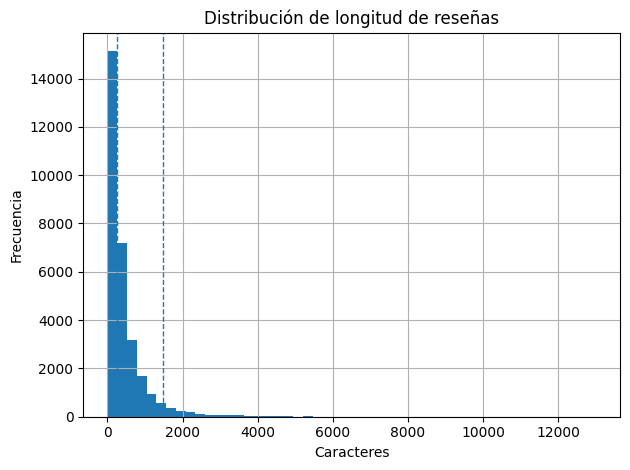

 Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_distribucion_longitud_resenas.png


In [25]:
#Detectar la columna de texto (probamos alias comunes)
if "text_col" not in locals():
    candidatas_texto = ["text", "reviewText", "review_text", "review_body", "body", "content", "review"]
    text_col = next((c for c in candidatas_texto if c in df.columns), None)
    if text_col is None:
        raise ValueError(
            f"No se encontró columna de texto. Debe existir alguna de: {candidatas_texto}"
        )
print(f"Usando columna de texto: {text_col}")

#Crear columna de longitud en caracteres (convertimos a str por seguridad ante NaNs)
df["text_len"] = df[text_col].astype(str).str.len()
print(df["text_len"].describe())

# Graficar histograma de longitudes
plt.figure()
df["text_len"].hist(bins=50)
plt.title("Distribución de longitud de reseñas")
plt.xlabel("Caracteres")
plt.ylabel("Frecuencia")

mediana = float(df["text_len"].median())
p95     = float(df["text_len"].quantile(0.95))
plt.axvline(mediana, linestyle="--", linewidth=1)
plt.axvline(p95,     linestyle="--", linewidth=1)
plt.tight_layout()

# Guardar archivo
fig_out = images_dir / f"{id_arch}distribucion_longitud_resenas.png"  # sin tildes/ñ en el nombre
plt.savefig(fig_out, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(" Imagen guardada en:", fig_out)

Palabras y n-gramas frecuentes por clase


=== POSITIVE | Unigramas ===


,frecuencia
phone,9035
great,4271
use,3178
good,3104
battery,2796
like,2643
just,2506
works,2407
product,2267
headset,2136


=== POSITIVE | Bigrams ===


,frecuencia
cell phone,797
battery life,667
works great,661
sound quality,559
easy use,394
bluetooth headset,370
great product,328
highly recommend,275
great price,183
really like,176



=== NEUTRAL | Unigramas ===


,frecuencia
phone,11449
good,3809
use,3430
like,3226
just,3189
headset,2986
ear,2608
case,2491
battery,2364
great,2343


=== NEUTRAL | Bigrams ===


,frecuencia
sound quality,796
cell phone,635
battery life,570
bluetooth headset,364
don know,287
works fine,249
does work,248
works great,227
use phone,216
easy use,214



=== NEGATIVE | Unigramas ===


,frecuencia
phone,10506
product,2814
just,2661
work,2606
use,2532
battery,2470
headset,2214
time,2144
like,1964
good,1955


=== NEGATIVE | Bigrams ===


,frecuencia
cell phone,639
sound quality,433
waste money,414
customer service,348
does work,328
did work,327
battery life,313
doesn work,251
didn work,246
bluetooth headset,235


 CSV guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/01_top_ngrams_por_clase.csv


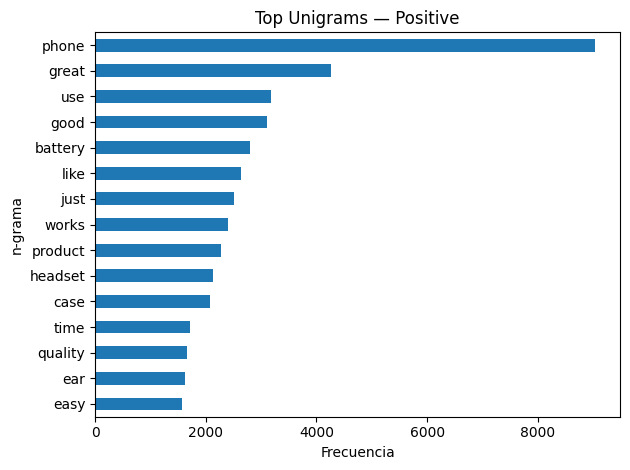

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_unigrams_positive.png


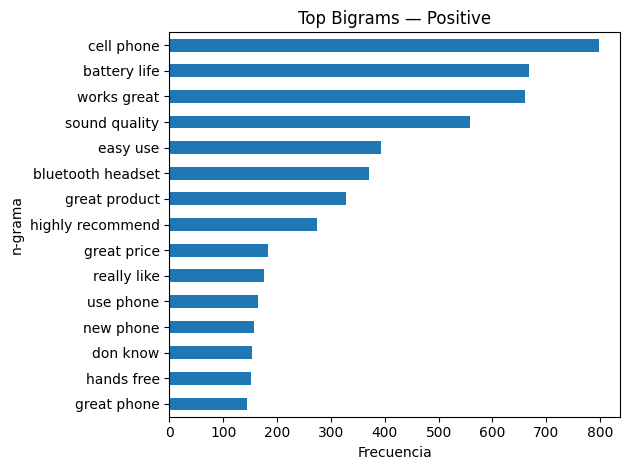

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_bigrams_positive.png


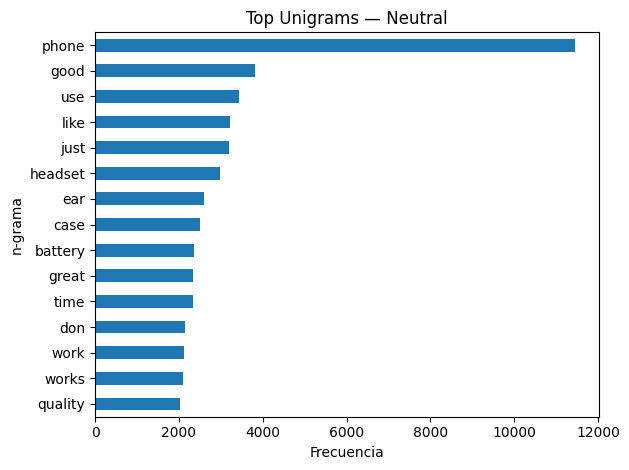

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_unigrams_neutral.png


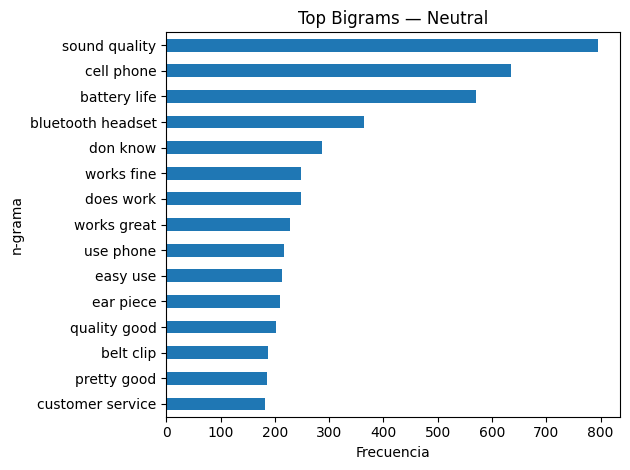

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_bigrams_neutral.png


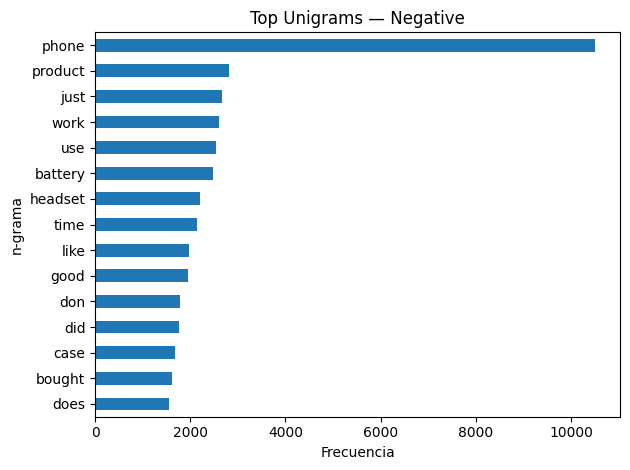

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_unigrams_negative.png


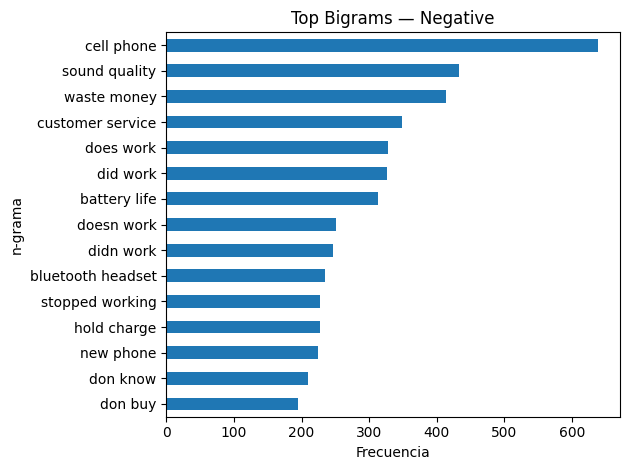

Imagen guardada: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/01_top_bigrams_negative.png


In [27]:
#Rutas de saida
images_dir    = Path(rutas.get_images_dir())      # docs/images
processed_dir = Path(rutas.get_processed_dir())   # data/processed
images_dir.mkdir(parents=True, exist_ok=True)     # por si no existiera

try:
    id_arch
except NameError:
    id_arch = "01_"                                # prefijo por defecto

out_img_dir = images_dir                           # << sin subcarpeta extra


# Normalizar 'label'
df["label"] = df["label"].astype(str).str.lower()

#  Helper: top n-gramas para un conjunto de textos
def top_ngrams(texts, ngram_range=(1,1), top_k=15, stop_words="english", min_df=2, max_features=None):
    """
    texts: Serie/iterable de strings
    ngram_range: (1,1)=unigramas, (2,2)=bigramas, etc.
    stop_words: 'english' para dataset en inglés; usa None si tu corpus es español.
    min_df: descarta términos que aparecen en < min_df documentos
    """
    vec = CountVectorizer(
        ngram_range=ngram_range,
        stop_words=stop_words,      # cambia a None si tu dataset no es inglés
        min_df=min_df,
        max_features=max_features
    )
    X = vec.fit_transform(texts.astype(str))
    freqs = pd.Series(X.sum(axis=0).A1, index=vec.get_feature_names_out())
    return freqs.sort_values(ascending=False).head(top_k)

# Calcular top n-gramas por clase
clases = [c for c in ["positive", "neutral", "negative"] if c in df["label"].unique()]
if not clases:
    raise ValueError("No se encontraron clases entre ['positive','neutral','negative'] en la columna 'label'.")

result_rows = []
tablas_por_clase = {}

for clase in clases:
    subset = df.loc[df["label"] == clase, text_col]
    if subset.empty:
        print(f"(Aviso) Clase '{clase}' sin textos; se omite.")
        continue

    top_uni = top_ngrams(subset, (1,1), top_k=15)   # unigramas
    top_bi  = top_ngrams(subset, (2,2), top_k=15)   # bigramas

    tablas_por_clase[clase] = {"unigramas": top_uni, "bigrams": top_bi}

    result_rows += [{"class": clase, "ngram_type": "unigram", "ngram": k, "freq": int(v)} for k, v in top_uni.items()]
    result_rows += [{"class": clase, "ngram_type": "bigram",  "ngram": k, "freq": int(v)} for k, v in top_bi.items()]


# Mostrar de forma amigable
for clase, tops in tablas_por_clase.items():
    print(f"\n=== {clase.upper()} | Unigramas ===")
    display(tops["unigramas"].to_frame("frecuencia"))
    print(f"=== {clase.upper()} | Bigrams ===")
    display(tops["bigrams"].to_frame("frecuencia"))
# Guardar CSV unificado con todos los resultados
top_df = pd.DataFrame(result_rows)
csv_out = processed_dir / f"{id_arch}top_ngrams_por_clase.csv"
top_df.to_csv(csv_out, index=False)
print(" CSV guardado:", csv_out)

# Helpers para graficar series como barras horizontales (más legible)
def plot_top(series, title, out_name):
    if series.empty:
        print(f"(Aviso) Serie vacía para '{title}'; no se genera imagen.")
        return
    fig, ax = plt.subplots()
    series.sort_values().plot(kind="barh", ax=ax)   # horizontal: más legible
    ax.set_title(title)
    ax.set_xlabel("Frecuencia")
    ax.set_ylabel("n-grama")
    fig.tight_layout()
    out_path = out_img_dir / out_name
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print("Imagen guardada:", out_path)

#Graficar por clase (unigramas y bigramas)
for clase in clases:
    uni_s = top_df[(top_df["class"] == clase) & (top_df["ngram_type"] == "unigram")] \
              .set_index("ngram")["freq"]
    bi_s  = top_df[(top_df["class"] == clase) & (top_df["ngram_type"] == "bigram")] \
              .set_index("ngram")["freq"]

    plot_top(uni_s, f"Top Unigrams — {clase.title()}", f"{id_arch}top_unigrams_{clase}.png")
    plot_top(bi_s,  f"Top Bigrams — {clase.title()}",  f"{id_arch}top_bigrams_{clase}.png")


Muestras por clase

In [28]:
#Verificaciones mínimas
try:
    df
except NameError:
    raise NameError("df no está definido. Carga tu DataFrame antes de esta celda.")

# Parámetros
n_muestras = 3
clases_objetivo = ["positive", "neutral", "negative"]
clases = [c for c in clases_objetivo if c in df["label"].unique()]

# Mostrar n muestras por clase
for clase in clases:
    subset = df.loc[df["label"] == clase, [text_col]]
    if subset.empty:
        print(f"(Aviso) Clase '{clase}' sin ejemplos.")
        continue
    # Si quieres aleatorio usa .sample(..., random_state=42) en lugar de .head(n_muestras)
    muestra = subset.head(n_muestras)
    print(f"\n### {clase.upper()} ({len(muestra)} ejemplos)")
    display(muestra.rename(columns={text_col: "text"}))




### POSITIVE (3 ejemplos)


,text
0,"Bought this for my husband (iphone 4), he had ..."
1,For under $20 I wasn't expecting much but was ...
4,There was a huge sigh of relief when 7105t cam...



### NEUTRAL (3 ejemplos)


,text
2,Thanks
16,The website did not pay enough attention to th...
18,UPDATED Feb 9th 2008: Well the BT5020 is now d...



### NEGATIVE (3 ejemplos)


,text
3,Purchased with the intent of boosting the cell...
6,I'd avoid this product unless you don't mind b...
9,The BlueAnt X3 Micro has bad reception and ran...


Conclusiones del Análisis Exploratorio (EDA)
* Balance de clases: El dataset contiene tres categorías de sentimiento: positivo, neutral y negativo, con una distribución equilibrada de 10,000 registros por clase, siendo beneficioso para el entrenamiento de modelos, ya que evita sesgos hacia una categoría específica.

* Calidad de los datos: Los tipos de datos están correctamente definidos para el procesamiento posterior (strings para texto, enteros para indicadores binarios de aspectos).

* Menciones de aspectos: El aspecto precio es el más mencionado en las reseñas, seguido de calidad y envío, esto sugiere que los clientes priorizan el costo del producto en sus evaluaciones.

* Distribución de sentimientos: La proporción equilibrada entre sentimientos positivos, neutros y negativos permite desarrollar modelos de clasificación sin aplicar técnicas de balanceo adicionales, la visualización confirma que no existe dominancia de una sola clase.
